## [Australian Tourism Hierarchy](https://otexts.com/fpp2/hts.html)

We are going to explore statistical models applied to a well-known hierarchical dataset called visnights, you can see more about it in above link from Hyndman's book. The major goal here is to test and evaluate performance of such models in this simple dataset. Later, we are going to apply machine learning models in order to make proper comparisons.

In [30]:
# Usual imports
import sys

sys.path.append("../src")

import os
from pprint import pprint
import importlib

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Download the raw files into this directory
data = '../data/raw/'

# helper functions
from visualize import get_nodes_edges_position, make_annotations, tsplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading Data

In [2]:
DATAPATH = os.path.join(data, "visnights")
os.listdir(DATAPATH)

['visnights.csv']

In [3]:
visnights = pd.read_csv(os.path.join(DATAPATH, "visnights.csv"))
visnights.head(7)

date state   zone  total_visitors_nights
0  1998-01-01   NSW  Metro            9047.095397
1  1998-04-01   NSW  Metro            6962.125890
2  1998-07-01   NSW  Metro            6871.963047
3  1998-10-01   NSW  Metro            7147.292612
4  1999-01-01   NSW  Metro            7956.922814
5  1999-04-01   NSW  Metro            6542.243263
6  1999-07-01   NSW  Metro            6330.364078

The hierarchy in this dataset is the following:
 - six geographic areas (NSW, QLD, SAU, VIC, WAU, OTH)
 - each geographic area can have a different number of zones, for example, NSW has five.
 
So in order to produce unique bottom series, let's create a new column where we concatenate state and zone.

In [4]:
visnights["state_zone"] = visnights.apply(lambda x: f"{x['state']}_{x['zone']}", axis=1)

### Visualizing Tree Structure

Let's create a simple plot of our tree structure so we can develop a better understanding of our dataset. We will use networkx and plotly to produce the visualization, so we need to create a list of tuples for each connection.

In [5]:
grouped_sections = visnights.groupby(["state", "state_zone"])
edges_hierarchy = list(grouped_sections.groups.keys())
edges_hierarchy[:7]

[('NSW', 'NSW_Metro'),
 ('NSW', 'NSW_NthCo'),
 ('NSW', 'NSW_NthIn'),
 ('NSW', 'NSW_SthCo'),
 ('NSW', 'NSW_SthIn'),
 ('OTH', 'OTH_Metro'),
 ('OTH', 'OTH_NoMet')]

Now, we must not forget total that is our root node.

In [6]:
second_level_nodes = ["NSW", "OTH", "WAU", "SAU", "QLD", "VIC"]
root_node = "total"

root_edges = [(root_node, second_level_node) for second_level_node in second_level_nodes]
root_edges

[('total', 'NSW'),
 ('total', 'OTH'),
 ('total', 'WAU'),
 ('total', 'SAU'),
 ('total', 'QLD'),
 ('total', 'VIC')]

In [7]:
root_edges += edges_hierarchy

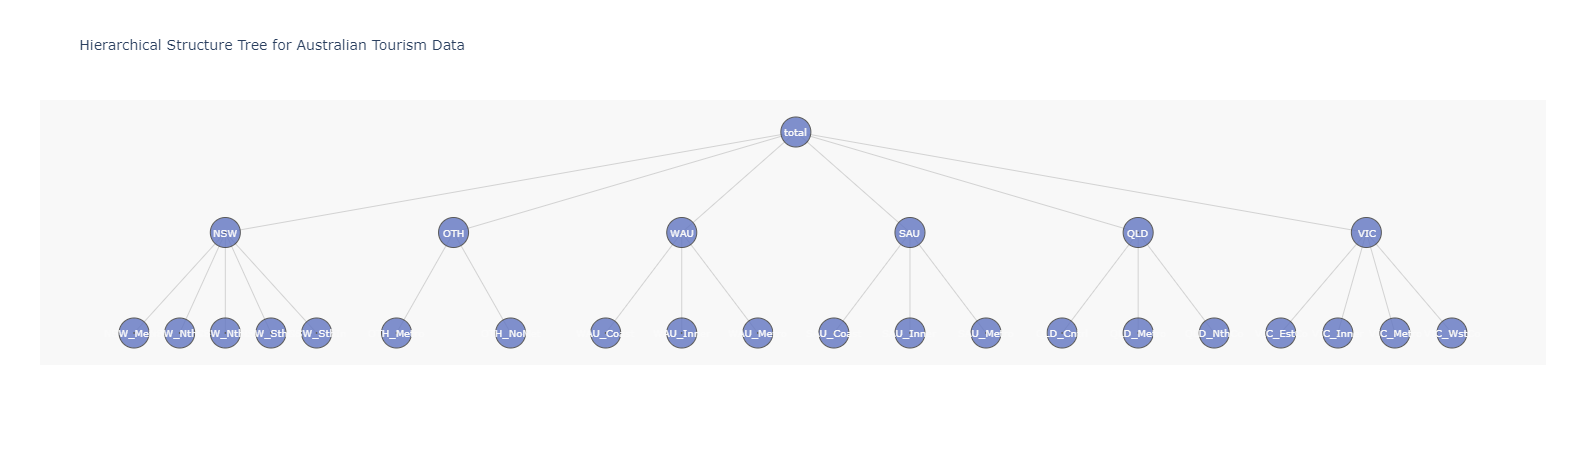

In [8]:
Xn, Yn, Xe, Ye, labels, annot = get_nodes_edges_position(root_edges, root="total")
M = max(Yn)

fig = go.Figure()

fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))

fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=30,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(title= 'Hierarchical Structure Tree for Australian Tourism Data',
              annotations=annot,
              font_size=10,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
              plot_bgcolor='rgb(248,248,248)'
              )
fig.show()

We can see above how our data is structured, now let's transform it in order to use scikit-hts properly.

### Transform data in the format required by scikit-hts

*scikit-hts* requires that each column in our DataFrame is a time series of its own, for all hierarchy levels. Let's do that. Remember that our data is in a long format.

The steps are the following:

1. Transform dataset into a column oriented one
2. Create the hierarchy representation as a dictionary
 
For a complete description of how that is done under the hood, and for a sense of what the API accepts, see [scikit-hts' docs](https://scikit-hts.readthedocs.io/en/latest/hierarchy.html)

In [9]:
visnights_bottom_level = visnights.pivot(index="date", columns="state_zone", values="total_visitors_nights")
visnights_bottom_level.head(5)

state_zone    NSW_Metro    NSW_NthCo    NSW_NthIn    NSW_SthCo    NSW_SthIn  \
date                                                                          
1998-01-01  9047.095397  8565.677890  2977.506662  5818.028804  2679.537963   
1998-04-01  6962.125890  7124.468362  3477.702717  2466.436706  3010.732155   
1998-07-01  6871.963047  4716.893116  3014.770331  1928.052834  3328.869005   
1998-10-01  7147.292612  6269.299065  3757.972112  2797.555974  2417.772236   
1999-01-01  7956.922814  9493.901336  3790.759900  4853.680680  3224.285428   

state_zone    OTH_Metro    OTH_NoMet    QLD_Cntrl     QLD_Metro    QLD_NthCo  \
date                                                                           
1998-01-01  3437.923945  2073.469372  2748.373689  12106.052376  2137.234012   
1998-04-01  2677.081107  1787.938519  4040.915256   7786.686688  2269.595619   
1998-07-01  3793.742887  2345.020634  5343.964347  11380.023616  4890.227020   
1998-10-01  3304.231082  1943.688721  4260.418878   9311.460272  2621.548165   
1999-01-01  3510.818728  2165.837870  4186.113263  12671.941529  2483.202540   

state_zone    SAU_Coast    SAU_Inner    SAU_Metro    VIC_EstCo    VIC_Inner  \
date                                                                          
1998-01-01  2591.997218   894.877294  2881.371786  3381.972183  5326.655137   
1998-04-01  1375.780128   979.250884  2124.735577  1827.940100  4441.118574   
1998-07-01  1079.541542   980.328853  2284.870236  1351.952120  3815.645302   
1998-10-01  1497.663951  1509.434264  1785.888968  1493.414796  3859.567145   
1999-01-01  2247.683952   963.522662  2293.872588  2896.928893  4588.755209   

state_zone    VIC_Metro    VIC_WstCo    WAU_Coast    WAU_Inner    WAU_Metro  
date                                                                         
1998-01-01  7490.381649  2442.004813  3066.555070   694.995372  3075.778941  
1998-04-01  5198.178082   960.504703  3334.405408   557.679575  2154.928814  
1998-07-01  5244.217363   755.974380  4365.844091  1006.184417  2787.286174  
1998-10-01  6274.245607  1271.603970  4521.995729  1172.551447  2752.909841  
1999-01-01  9187.421553  2385.058308  3579.346592   398.182909  3519.564374

We still need data aggregate by state and the total column.

In [16]:
def get_state_columns(df, state):
    return [col for col in df.columns if state in col]

states = visnights["state"].unique().tolist()

for state in states:
    state_cols = get_state_columns(visnights_bottom_level, state)
    visnights_bottom_level[state] = visnights_bottom_level[state_cols].sum(axis=1)

visnights_bottom_level["total"] = visnights_bottom_level[states].sum(axis=1)

visnights_bottom_level.head(5)

state_zone    NSW_Metro    NSW_NthCo    NSW_NthIn    NSW_SthCo    NSW_SthIn  \
date                                                                          
1998-01-01  9047.095397  8565.677890  2977.506662  5818.028804  2679.537963   
1998-04-01  6962.125890  7124.468362  3477.702717  2466.436706  3010.732155   
1998-07-01  6871.963047  4716.893116  3014.770331  1928.052834  3328.869005   
1998-10-01  7147.292612  6269.299065  3757.972112  2797.555974  2417.772236   
1999-01-01  7956.922814  9493.901336  3790.759900  4853.680680  3224.285428   

state_zone    OTH_Metro    OTH_NoMet    QLD_Cntrl     QLD_Metro    QLD_NthCo  \
date                                                                           
1998-01-01  3437.923945  2073.469372  2748.373689  12106.052376  2137.234012   
1998-04-01  2677.081107  1787.938519  4040.915256   7786.686688  2269.595619   
1998-07-01  3793.742887  2345.020634  5343.964347  11380.023616  4890.227020   
1998-10-01  3304.231082  1943.688721  4260.418878   9311.460272  2621.548165   
1999-01-01  3510.818728  2165.837870  4186.113263  12671.941529  2483.202540   

state_zone  ...    WAU_Coast    WAU_Inner    WAU_Metro           NSW  \
date        ...                                                        
1998-01-01  ...  3066.555070   694.995372  3075.778941  58175.693432   
1998-04-01  ...  3334.405408   557.679575  2154.928814  46082.931658   
1998-07-01  ...  4365.844091  1006.184417  2787.286174  39721.096665   
1998-10-01  ...  4521.995729  1172.551447  2752.909841  44779.783995   
1999-01-01  ...  3579.346592   398.182909  3519.564374  58639.100317   

state_zone           QLD           SAU           VIC           WAU  \
date                                                                 
1998-01-01  33983.320155  12736.492596  37282.027564  13674.658766   
1998-04-01  28194.395126   8959.533177  24855.482919  12094.027593   
1998-07-01  43228.429966   8689.481260  22335.578328  16318.629363   
1998-10-01  32386.854629   9585.974367  25797.663035  16894.914034   
1999-01-01  38682.514663  11010.158405  38116.327926  14994.187752   

state_zone           OTH          total  
date                                     
1998-01-01  11022.786635  166874.979147  
1998-04-01   8930.039253  129116.409726  
1998-07-01  12277.527043  142570.742626  
1998-10-01  10495.839606  139941.029666  
1999-01-01  11353.313195  172795.602258  

[5 rows x 27 columns]

Now that we have our dataset ready, let's define our hierarchy tree. We need a dictionary, where each key is a column (node) in our hierarchy and a list of its children.

In [17]:
hierarchy = dict()

for edge in root_edges:
    parent, children = edge[0], edge[1]
    hierarchy.get(parent)
    if not hierarchy.get(parent):
        hierarchy[parent] = [children]
    else:
        hierarchy[parent] += [children]

In [18]:
hierarchy

{'total': ['NSW', 'OTH', 'WAU', 'SAU', 'QLD', 'VIC'],
 'NSW': ['NSW_Metro', 'NSW_NthCo', 'NSW_NthIn', 'NSW_SthCo', 'NSW_SthIn'],
 'OTH': ['OTH_Metro', 'OTH_NoMet'],
 'QLD': ['QLD_Cntrl', 'QLD_Metro', 'QLD_NthCo'],
 'SAU': ['SAU_Coast', 'SAU_Inner', 'SAU_Metro'],
 'VIC': ['VIC_EstCo', 'VIC_Inner', 'VIC_Metro', 'VIC_WstCo'],
 'WAU': ['WAU_Coast', 'WAU_Inner', 'WAU_Metro']}

## Fitting our models

Before using hts library to make predictions of all nodes, I want to use total node as a toy example to fit an ARIMA model and demonstrate the difficulties in this process and how would be a burden to do that for all nodes in our time series.

## SARIMA on total visitors series

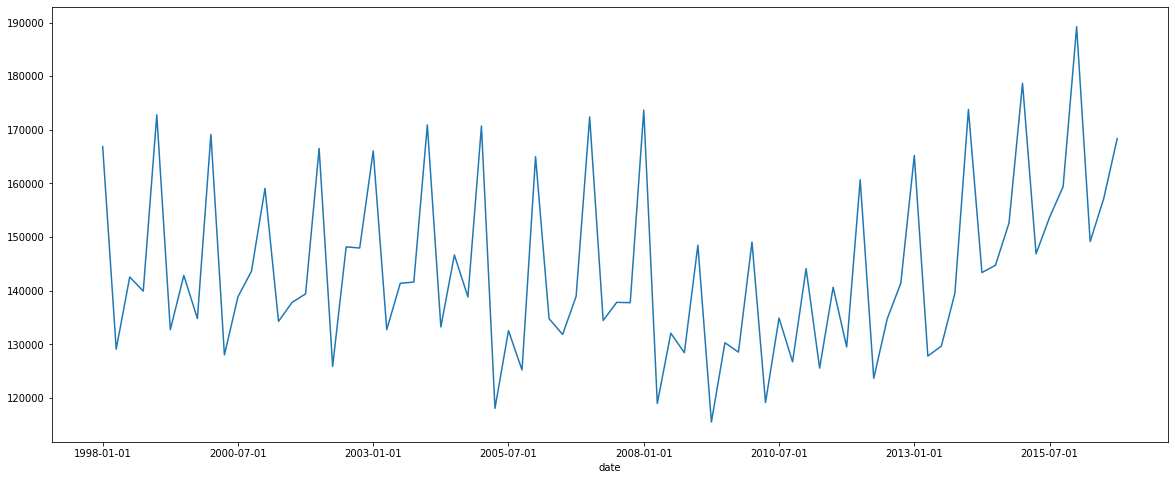

In [19]:
df_total = visnights_bottom_level['total'].copy()
df_total.plot(figsize=(20, 8))

The first step is to analyze visually our series, for the sake of brevity, I will be short on this.
We can check some things in your data:

 - There is no apparent trend that dominates our series. However, up to 2008 the series seemed constant and then a drop followed by a steep increase occurred. This may indicate some change in the data generation process, but again, for simplicity and for not having extra information on data I will ignore this, but in a real project this could be a concern and something to check.
 - There is a strong seasonality. A six-month / annual seasonal factor may be used to model our data.
 - No evident outliers, although fluctuation discussed above may cause problems on predicting data.
 - No long-run cycle.
 - The variance seems constant overtime, but we can extra check that.
 - There is an abrupt change, but as discussed, we will take it for granted.

### Stationarity and differencing

One of the assumption of a ARIMA model is that our series are stationarity, basically, it means the series have constant variance and mean overtime as well as covariance of adjacency times constant, that is, [properties of the series do not depend on time.](https://otexts.com/fpp2/stationarity.html)

We can deal with non-stationarity series by differencing them. We can use ACF and PACF plots to check which difference terms would be appropriate for this model.

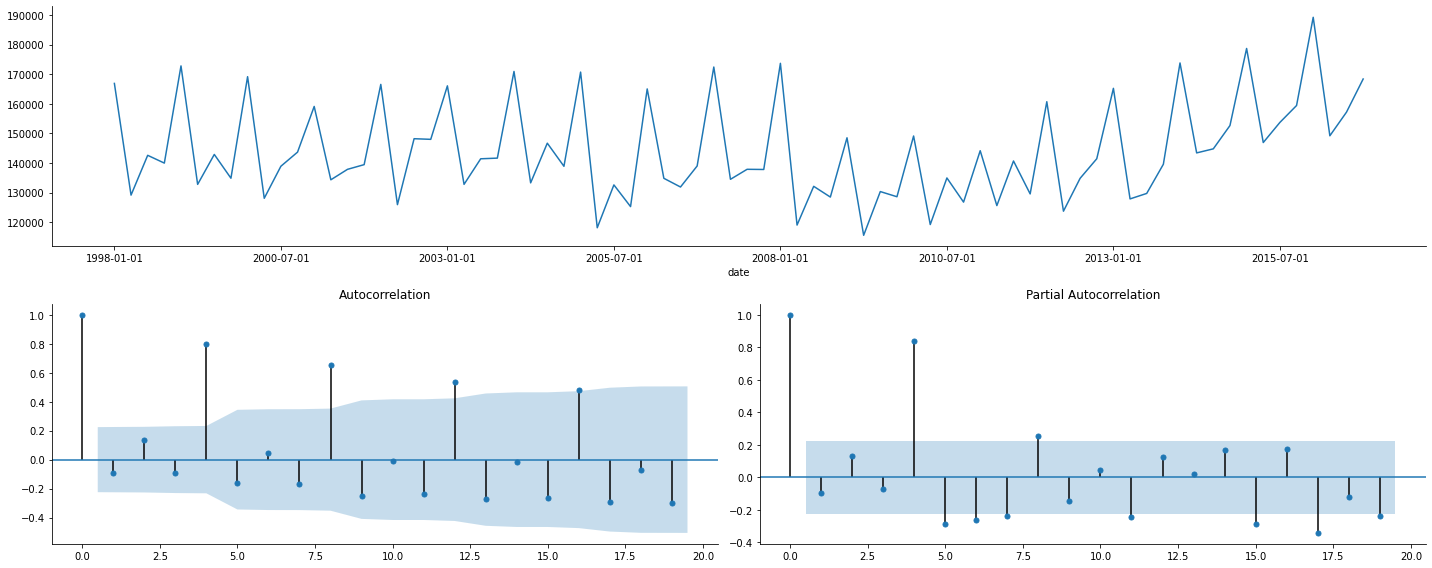

In [20]:
tsplot(df_total, figsize=(20, 8));

Data has a quaterly periodicity, so using D=1 with m=4 would be the correct approach when modelling our series. Let's plot the differenced series.

**Note:** Remember that for a seasonal series, our difference one is given by:

$$ y'_{t} = y_{t} - y_{t-m} $$

where for quarterly data, m=4.

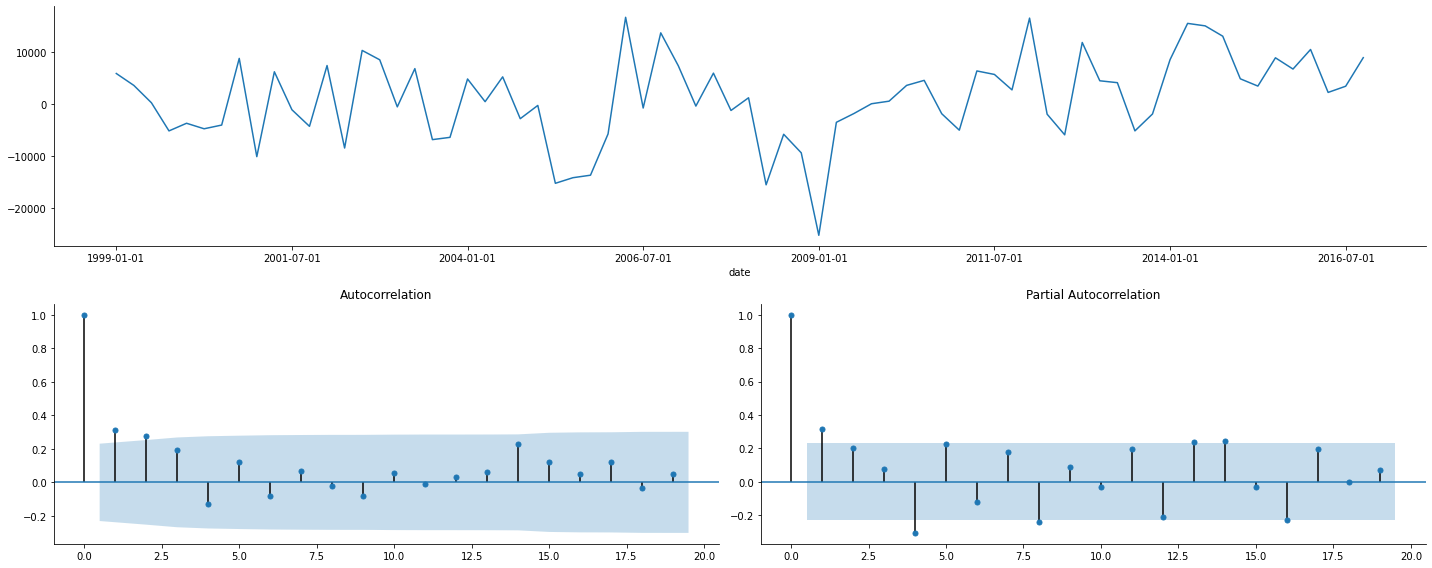

In [21]:
tsplot(df_total.diff(4).dropna(), figsize=(20, 8));

It seems better now. As Hyndman discuss in his book, choosing the right parameters for differencing terms, and also for AR and MA models in general can be tricky. I will use a simple one here, but it is acceptable an argument that further differencing is required. We live with choices, and that's what matters. :)

Defining SARIMA parameters is a difficult task, but we will try our best:

 - $ p $ is probably 1 from PACF plot.
 - $ d $ is equal to 0, since we did not have a trend.
 - $ q $ is likely 1 from ACF plot.
 - $ P $ might be 2.
 - $ D $ is equal to one since we performed seasonal differentiation.
 - $ Q $ is likely 0.
    
Let's fit then  SARIMA(1, 0, 1)x(2, 1, 0)x4 model with our data.

In [22]:
from pmdarima.model_selection import train_test_split
from pmdarima import AutoARIMA, ARIMA

train_total, test_total = train_test_split(df_total, test_size=0.20)

order = (1, 0, 1)
seasonal_order = (2, 1, 0, 4)

parameters = dict(order=order, 
                  seasonal_order=seasonal_order)

sarima_clf = ARIMA(**parameters)
sarima_clf.fit(train_total)

ARIMA(order=(1, 0, 1), seasonal_order=(2, 1, 0, 4))

Let's analyze how our model is performing regardings Mean Absolute Error, compared to all naive approaches and graphically.

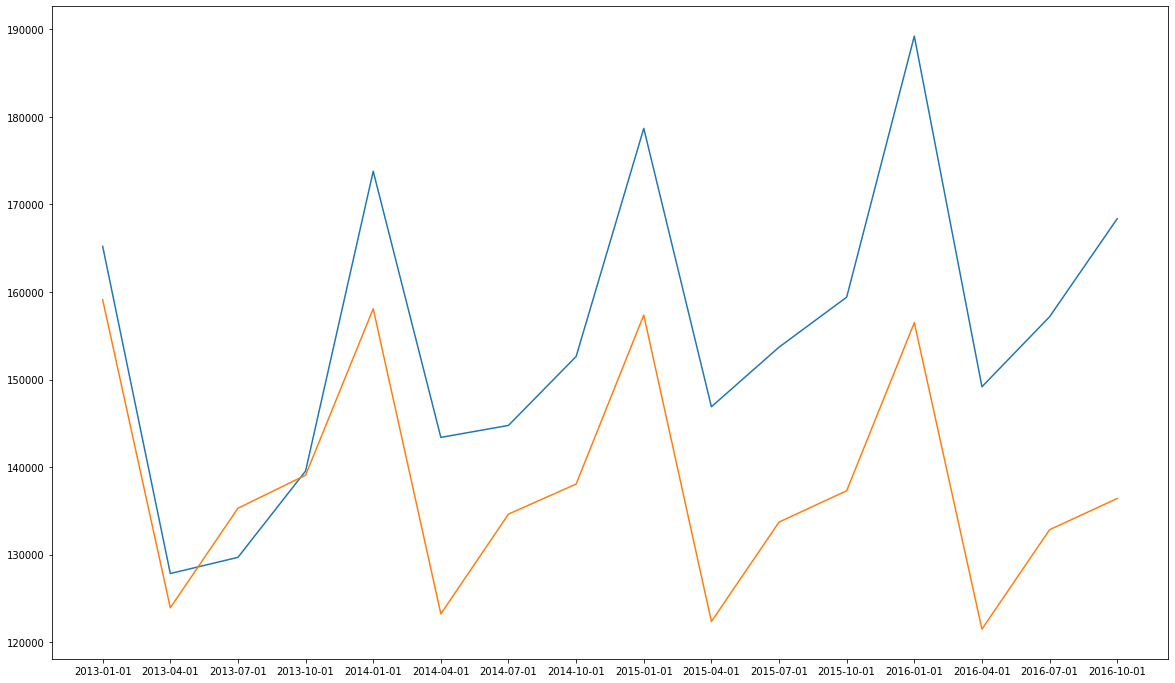

In [29]:
predicted = sarima_clf.predict(test_total.shape[0])

fig, ax = plt.subplots(figsize=(20, 12))

ax.plot(test_total.index, test_total.values)
ax.plot(test_total.index, predicted);

In [48]:
def print_results(train, test, pred, naive):
    print("Calculating MAE for a few naive approaches and model")
    print(f"Model: {mean_absolute_error(test, pred)}")
    print(f"Average: {mean_absolute_error(test, np.repeat(np.mean(train), test.shape[0]))}")
    print(f"Seasonal Naive: {mean_absolute_error(test, naive)}")
          
naive = pd.concat([train_total, test_total]).shift(4).values[-test_total.shape[0]:]
print_results(train_total.values, test_total.values, predicted, naive)

Calculating MAE for a few naive approaches and model
Model: 17583.487943786637
Average: 17016.830384508336
Seasonal Naive: 7331.737172174996


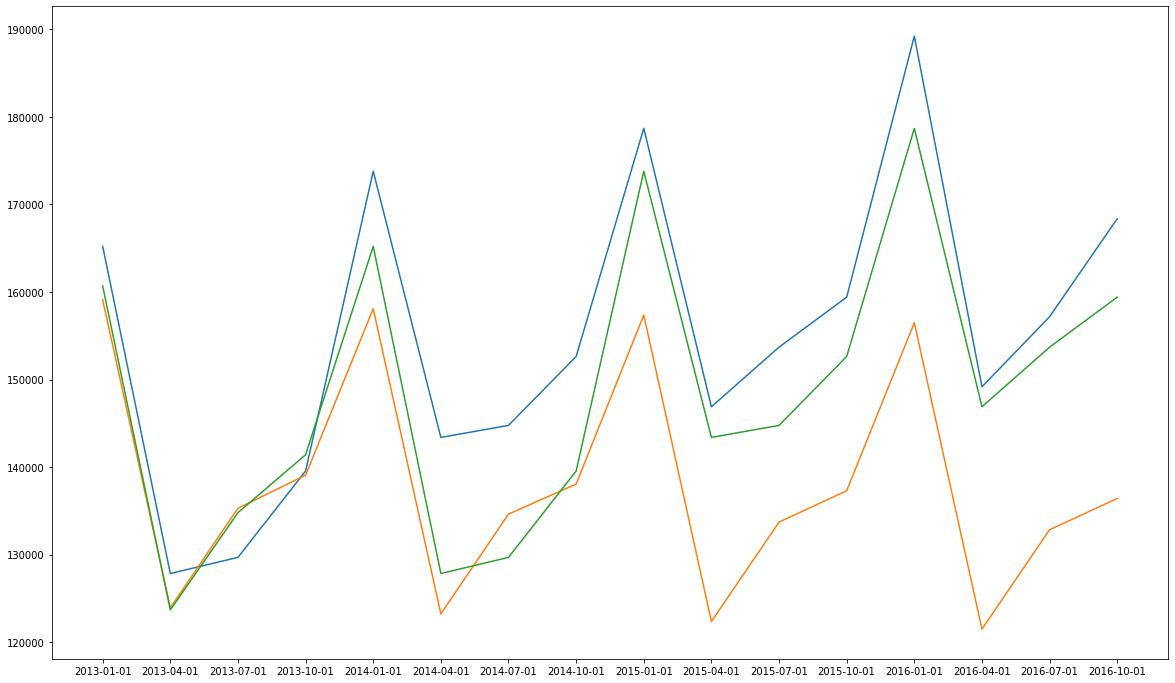

In [49]:
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot(test_total.index, test_total.values)
ax.plot(test_total.index, predicted);
ax.plot(test_total.index, naive);

We can see clearly from metrics and graph above that our model performs poorly. Let's try out autoarima.

In [56]:
auto_arima_clf = AutoARIMA(seasonal=True, m=4)
auto_arima_clf.fit(train_total)

AutoARIMA(m=4)

In [57]:
auto_arima_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:                       y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0, 4)   Log Likelihood                -583.538
Date:                 Mon, 03 Aug 2020   AIC                           1169.076
Time:                         10:02:58   BIC                           1171.102
Sample:                              0   HQIC                          1169.862
                                  - 60                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       6.13e+07   9.49e+06      6.459      0.000    4.27e+07    7.99e+07
===================================================================================
Ljung-Box (Q):                       54.76   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.06   Prob(JB):                         0.40
Heteroskedasticity (H):               2.11   Skew:                            -0.35
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

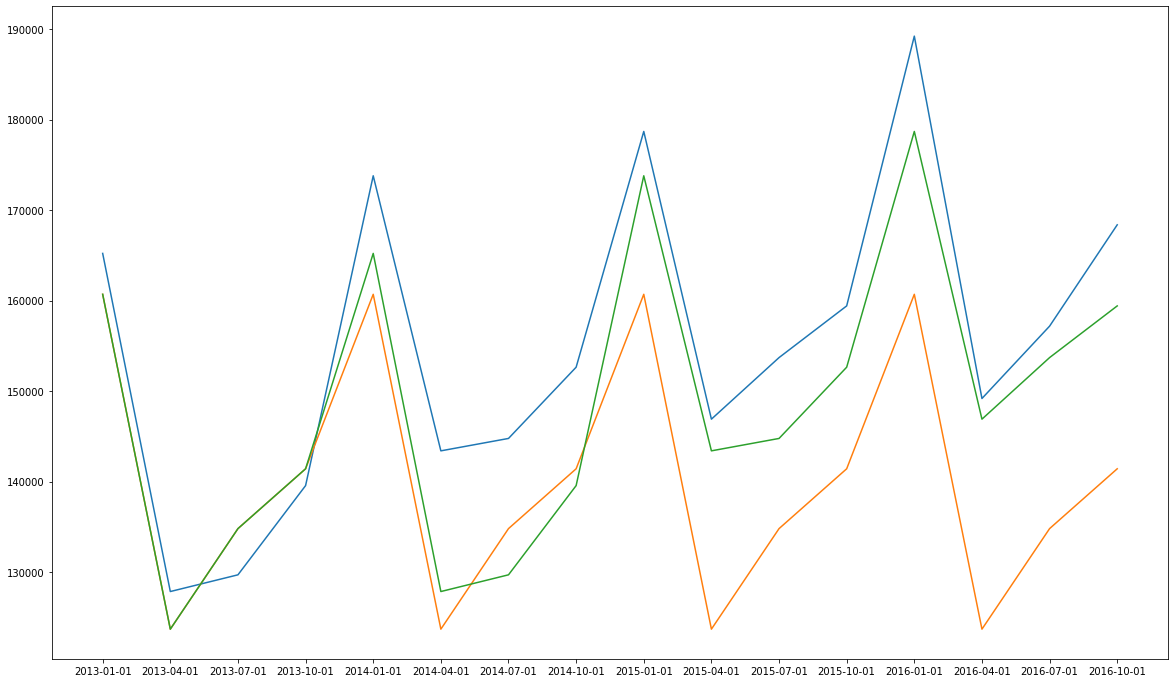

In [58]:
fig, ax = plt.subplots(figsize=(20, 12))

predicted_auto = auto_arima_clf.predict(test_total.shape[0])

ax.plot(test_total.index, test_total.values)
ax.plot(test_total.index, predicted_auto);
ax.plot(test_total.index, naive);

In [60]:
print_results(train_total.values, test_total.values, predicted_auto, naive)

Calculating MAE for a few naive approaches and model
Model: 15696.080371012507
Average: 17016.830384508336
Seasonal Naive: 7331.737172174996


That is interesting. None of ARIMA options performed best than a simple naive model. This occur more frequently than expected. In this case, it is clear from plotting the whole series that we have a change in the series right in our train-test split, in a way that our train does not capture any trend, what happens at the end of our test. This is an excellent demonstration how things can work in the real world, because when working with ARIMA models, one of the assumptions is about constant covariance, that is, data process generation does not change with time, which for long series can be quit unrealistic. 

Let's forecast now for all nodes in our series and analyze results.

Let's fit a few different models in our data and compare results.

#### Auto-Arima and Hierarchical models

First let's use scikit-hts to fit an ARIMA model specifically, the auto-arima implemented in the excellent pmdarima library.

In [61]:
from hts import HTSRegressor
from pmdarima.model_selection import train_test_split

train, test = train_test_split(visnights_bottom_level, test_size=8)

print(f"train shape: {train.shape}\t test shape: {test.shape}")

clf = HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0, m=4)
model = clf.fit(train, hierarchy)

Fitting models:   0%|          | 0/27 [00:00<?, ?it/s]

train shape: (68, 27)	 test shape: (8, 27)


Fitting models: 100%|██████████| 27/27 [04:54<00:00, 10.89s/it]


Now we can predict results for each node.

In [16]:
predicted_autoarima = model.predict(steps_ahead=8)

Fitting models: 100%|██████████| 27/27 [00:00<00:00, 110.16it/s]


Let's visualize the model results and fitted values for all states.

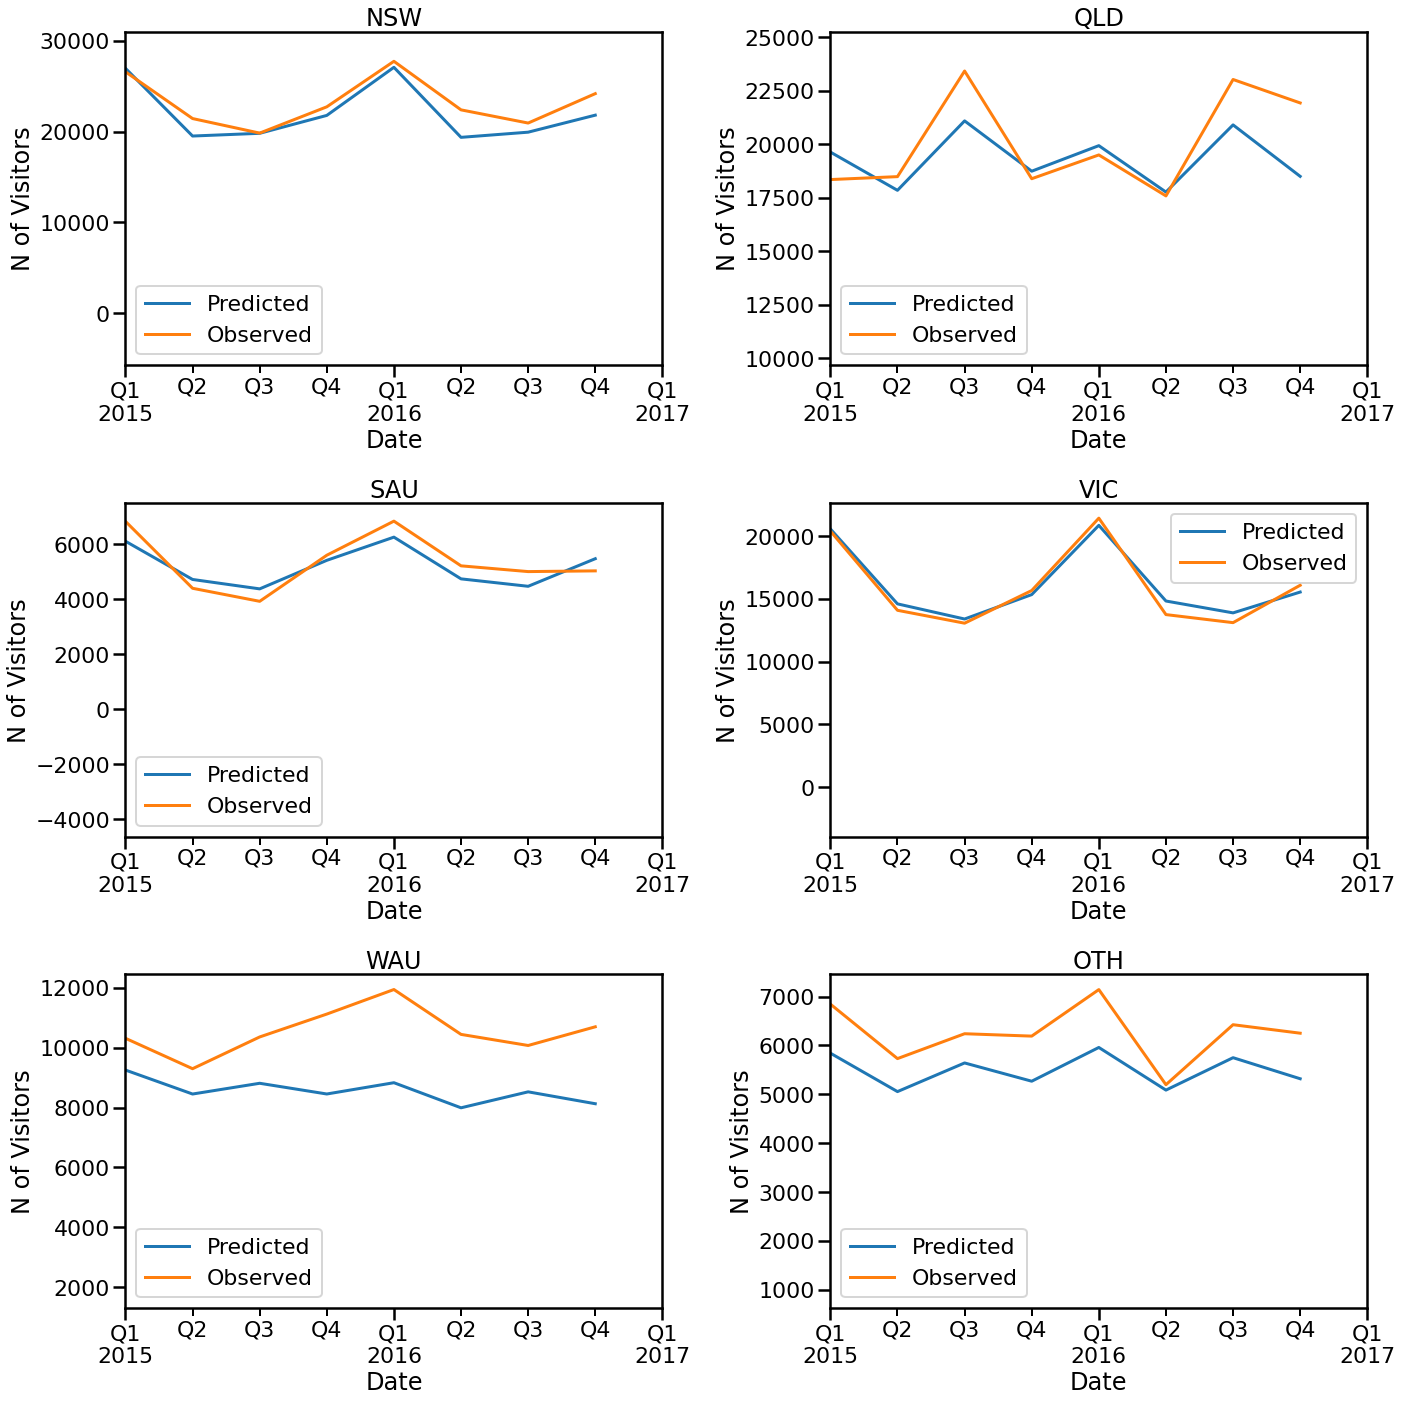

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

def plot_results(cols, axes, preds):
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        preds[col].plot(ax=ax, label="Predicted")
        visnights_bottom_level[col].plot(ax=ax, label="Observed")

        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("N of Visitors")
        ax.set_xlim('2015', '2017')
    
plot_results(states, axes, predicted_autoarima)
plt.tight_layout()

Of course, you can also check results for specific, nodes, let's get for OTH:

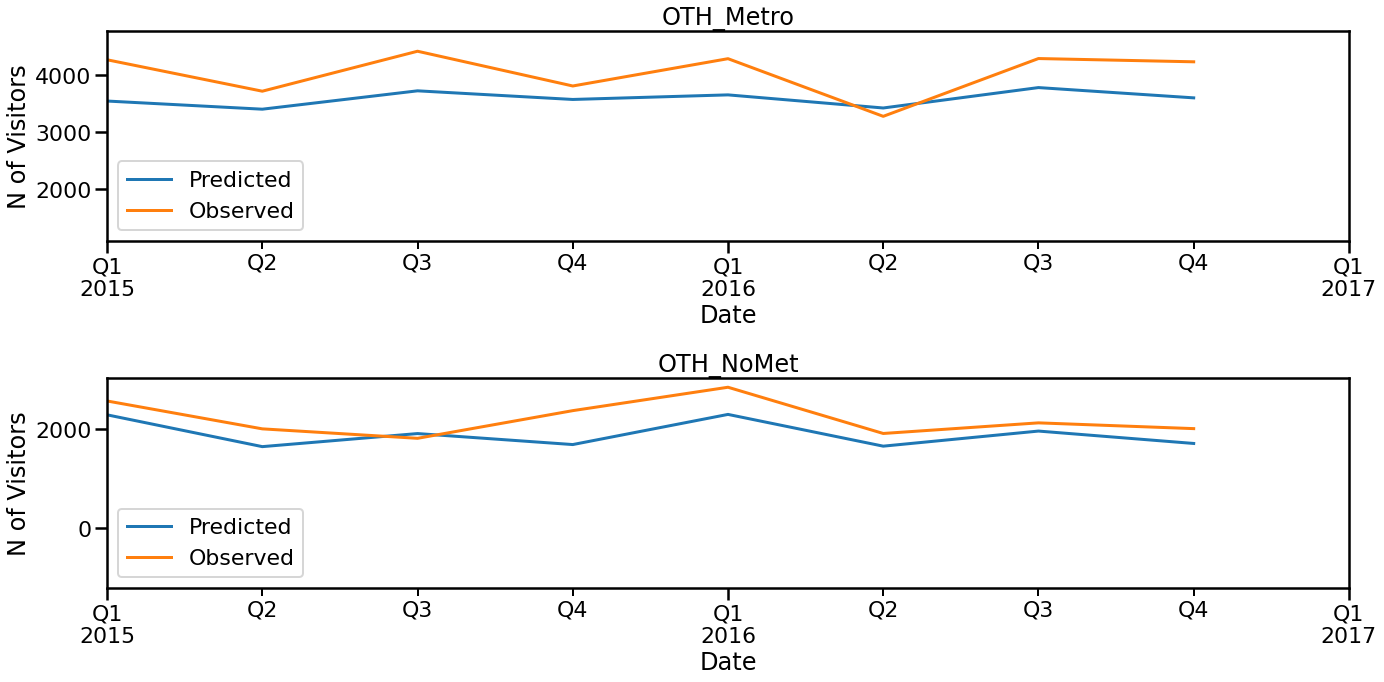

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
plot_results(state_cols, axes, predicted_autoarima)
plt.tight_layout()

## Analyzing Results

Our data has a hierarchical structure with different scales of visitors in each region / macroregion. Thus, it is important to analyze overall results base on metric that deal with this variance. We will use MASE to check our results and compare models.

In [19]:
from hts.metrics import mean_absolute_scaled_error

y_train = train
y_true = test
y_pred = predicted_autoarima[-test.shape[0]:]
    
y_train.shape, y_true.shape, y_pred.shape

((68, 27), (8, 27), (8, 27))

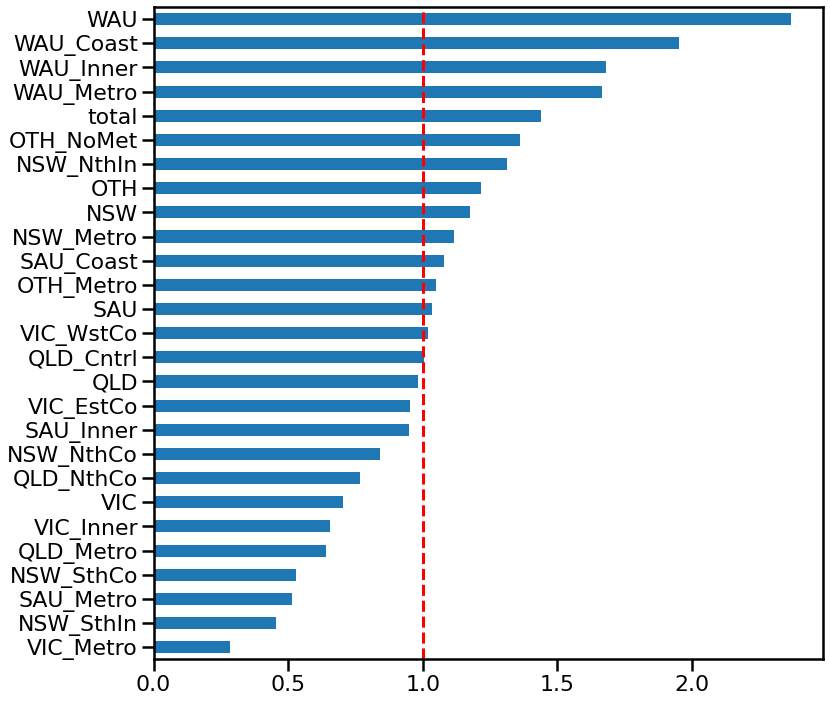

In [20]:
ax = mean_absolute_scaled_error(y_true, y_pred, y_train, m=4).sort_values().plot(kind='barh', figsize=(12, 12))

ax.axvline(x=1, linestyle='--', color='red')

Intuitively, if error is above 1, it means we have a model that performs worse than a simple naive method, in this case, since seasonality is equal to 4, m=4. However, we have a long horizont we want to predict (8 quartes, which is equivalent to 2 years), so we would expect worse forecast errors, because in this scenario our cut-point increases.

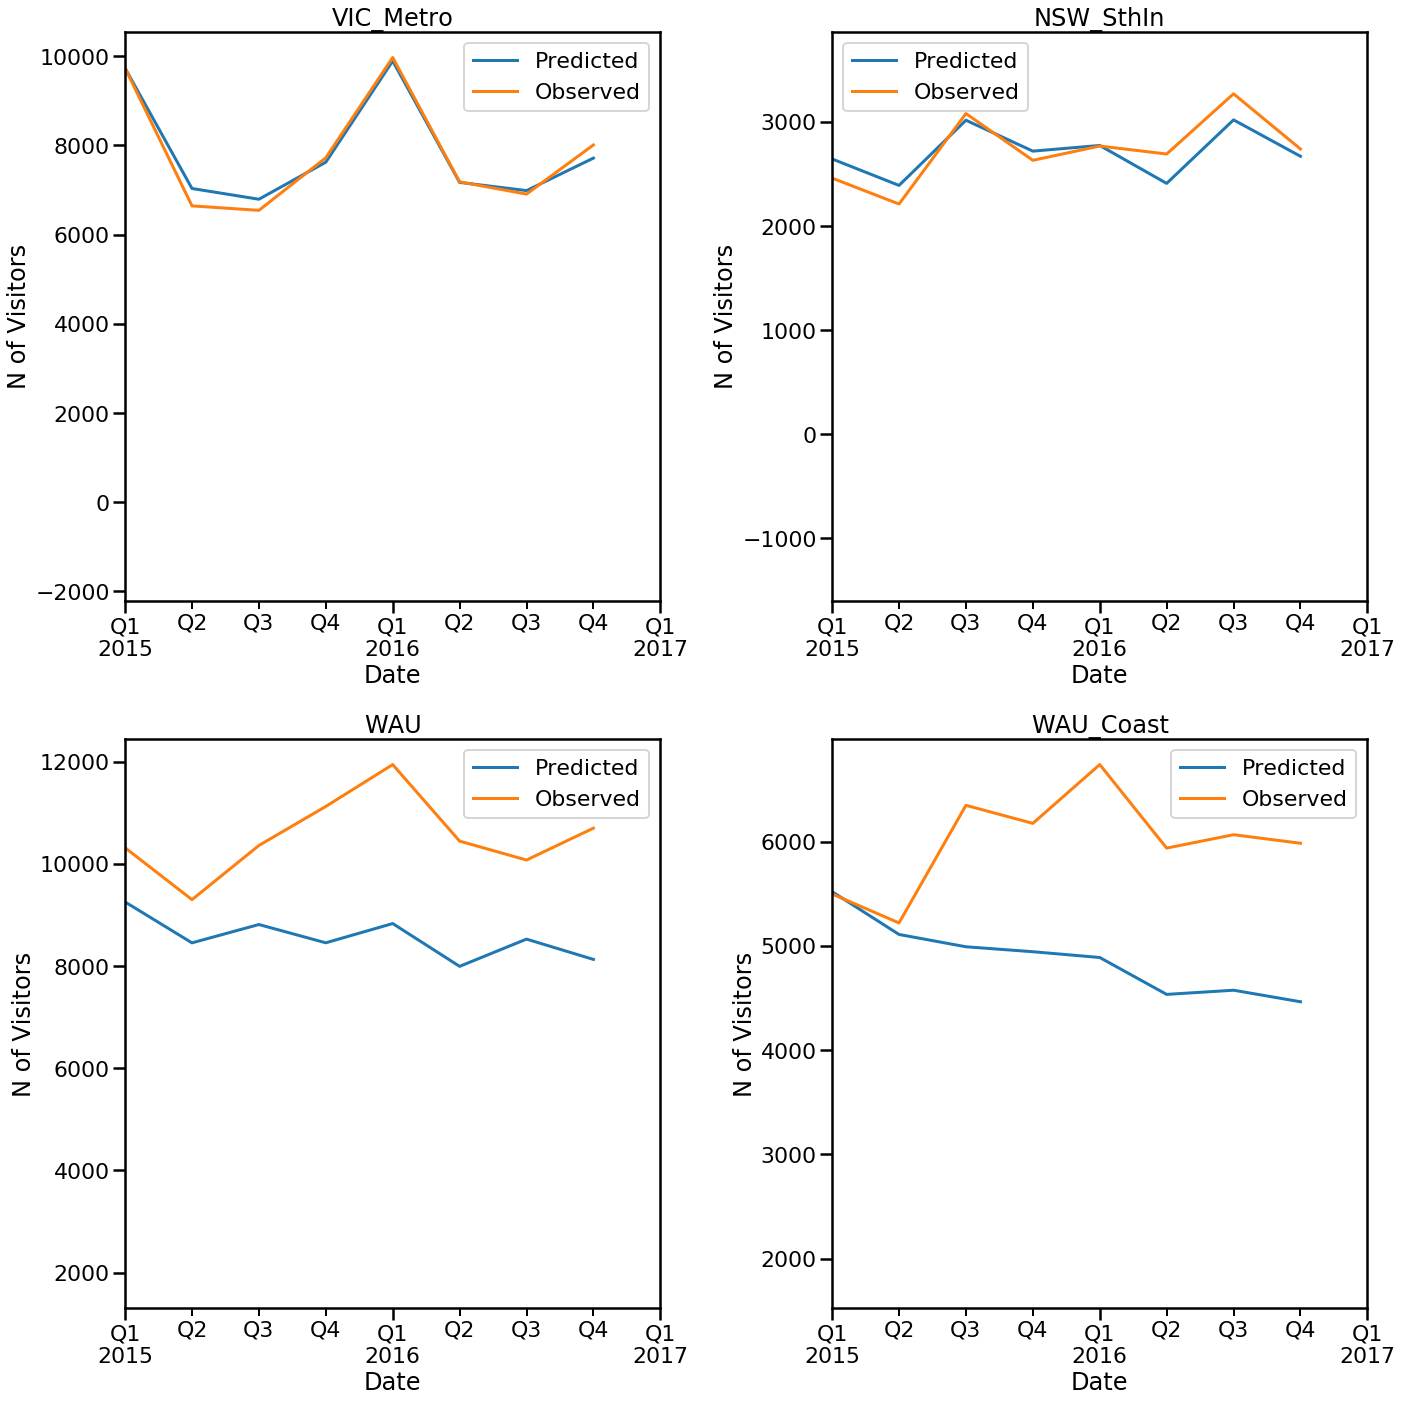

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20), sharey=False)

two_best_and_two_worst = ["VIC_Metro", "NSW_SthIn", "WAU", "WAU_Coast"]

plot_results(two_best_and_two_worst, axes, predicted_autoarima)
plt.tight_layout()

### RollingCV with MASE error

In the above approach, we just predicted 2 years directly from data and go back results. This is somehow simulating a real world scenario where we wnat to work with long scenarios. However, just doing split on train / test sample can bring biased results.

In [49]:
from pmdarima.model_selection import RollingForecastCV

rolling_cv = RollingForecastCV(h=2, step=1, initial=train.shape[0])


def cross_val_predict(estimator, df, hierarchy, cv):
    total_errors = {}
    
    for i, split_idx in enumerate(cv.split(df)):
        train_idx, test_idx = split_idx[0], split_idx[1]
        
        y_train = df.iloc[train_idx, :]
        y_true = df.iloc[test_idx, :]
        
        estimator.fit(y_train, hierarchy)
        y_pred = estimator.predict(steps_ahead=2).iloc[test_idx, :]
        
        mase_error = mean_absolute_scaled_error(y_true, y_pred, y_train, m=4)
        total_errors[i] = mase_error
        
    return total_errors

cross_val_results = cross_val_predict(clf, visnights_bottom_level, hierarchy, rolling_cv)

Fitting models: 100%|██████████| 27/27 [00:00<00:00, 108.55it/s]


In [98]:
pd.DataFrame(cross_val_results).agg(['mean', 'std'], axis=1)

mean       std
NSW        0.841518  0.226834
NSW_Metro  0.811872  0.506984
NSW_NthCo  0.958257  0.726299
NSW_NthIn  1.524045  0.255210
NSW_SthCo  0.887670  0.389159
NSW_SthIn  0.492717  0.267821
OTH        1.037641  0.379804
OTH_Metro  0.972805  0.366859
OTH_NoMet  0.978208  0.553103
QLD        0.699916  0.410125
QLD_Cntrl  0.654100  0.236199
QLD_Metro  0.444511  0.221577
QLD_NthCo  0.753281  0.635966
SAU        0.963481  0.503617
SAU_Coast  1.002269  0.506968
SAU_Inner  0.922011  0.859912
SAU_Metro  0.637314  0.333052
VIC        0.688553  0.261197
VIC_EstCo  0.900333  0.451549
VIC_Inner  0.639474  0.566110
VIC_Metro  0.349405  0.129460
VIC_WstCo  1.365537  0.436601
WAU        1.190300  0.547202
WAU_Coast  0.949756  0.604542
WAU_Inner  1.199343  0.449294
WAU_Metro  1.264204  0.797091
total      0.815611  0.371413

We can see that performance for all hierarchical levels are relatively good, with highlights for VIC_Metro which achieves 0.34 error.